In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pickle

import gmmhmm

In [2]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

def predict(mfcc_array, models):
    M = -np.inf
    ind = 0
    for i,model in enumerate(models):
        val = model.score(mfcc_array)
        if val > M:
            ind = i
            M = val
    return ind # FIXME: only works for digits

def get_model(value):
    with open(f"model_digit_{value}.pk", 'rb') as fin:
        model = pickle.load(fin)
    return model

# Load Data

In [21]:
test = pd.read_csv("Test_Arabic_Digit.txt", header=None, sep=' ')
test = np.split(test, test[test.isnull().all(1)].index)
test = [df[1:].reset_index().drop('index', axis=1).values for df in test[1:]]
test = np.array([arr[:4] for arr in test])

train = pd.read_csv("Train_Arabic_Digit.txt", header=None, sep=' ')
train = np.split(train, train[train.isnull().all(1)].index)
train = [df[1:].reset_index().drop('index', axis=1).values for df in train[1:]]
# train = np.array([arr[:4] for arr in train])

test_target_number = [i for i in range(10) for _ in range(220)]
test_target_gender = [gender for _ in range(10) for gender in ['m', 'f'] for _ in range(110)]

train_target_number = np.array([i for i in range(10) for _ in range(660)])
train_target_gender = np.array([gender for _ in range(10) for gender in ['m', 'f'] for _ in range(330)])
train[0].shape

(38, 13)

In [ ]:
# If train() takes data as single argument instead of 2
# train_number = np.hstack((train_data, train_target_number.reshape(-1,1)))
# train_gender = np.hstack((train_data, train_target_gender.reshape(-1,1)))

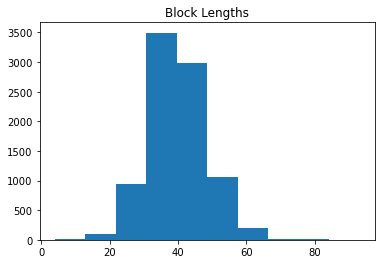

In [128]:
plt.hist([len(df) for df in test+train])
plt.title("Block Lengths")
plt.show()

# Train HMMs

In [29]:
# numbers = np.array([train[train_target_number == num,:] for num in np.unique(train_target_number)])
numbers = []
for num in np.unique(train_target_number):
#     numbers.append(train[train_target_number == num,:])
    numbers.append([train[i] for i in np.where(train_target_number == num)[0]])


(38, 13)

In [33]:
number_models = []
gender_models = []

for single_number_data in numbers:
    # Train GMMHMM on single_number_data
    startprob, transmat = initialize(5)
    hmm = gmmhmm.GMMHMM(n_components=5, n_mix=3, transmat=transmat, startprob=startprob, cvtype='diag')
    hmm.covars_prior = 0.01
    hmm.fit(single_number_data, init_params='mc', var=0.1)
    number_models.append(hmm)

In [35]:
for i,model in enumerate(number_models):
    with open(f"model_digit_{i}.pk", 'wb') as fout:
        pickle.dump(model,fout)

# Test HMMs

In [17]:
models = [get_model(i) for i in range(10)]
pred = []
correct = 0
for obs, target in zip(test, test_target_number):
    pred.append(predict(obs,models))
    if predict(obs, models) == target:
        correct += 1
correct / len(test)

0.5809090909090909

In [20]:
df = pd.DataFrame(data={'Prediction':pred, 'Ground Truth': test_target_number})
df

Prediction  Ground Truth
0              6             0
1              6             0
2              6             0
3              6             0
4              6             0
...          ...           ...
2195           9             9
2196           3             9
2197           9             9
2198           6             9
2199           6             9

[2200 rows x 2 columns]